### Import Libraries and Functions

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

In [2]:
def k_fold(df, k):
    # randomly shuffle rows
    df = df.sample(frac=1).reset_index(drop=True)
    num_rows = df.shape[0]
    df['k_fold'] = np.repeat(np.nan, num_rows)
    num_extra_rows = num_rows % k
    if num_extra_rows != 0:
        num_rows_in_each_fold = math.floor(num_rows / k)
    else:
        num_rows_in_each_fold = num_rows / k
    if num_extra_rows > 0:
        last_slice = 0
        for fold in range(k):
            if fold < num_extra_rows:
                df.loc[fold * (num_rows_in_each_fold+1):(num_rows_in_each_fold+1)*(fold+1),\
                       'k_fold'] = fold
                last_slice = (num_rows_in_each_fold+1)*(fold+1)
            else:
                df.loc[last_slice:last_slice+num_rows_in_each_fold, 'k_fold'] = fold
                last_slice = last_slice+num_rows_in_each_fold
        return df
    else:
        for fold in range(k):
            df.loc[fold * (num_rows_in_each_fold):(num_rows_in_each_fold)*(fold+1),\
                   'k_fold'] = fold
        return df

### Decision Tree Regression

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score

In [17]:
# Import data
train_df = pd.read_csv('OnlineNewsPopularityTrain.csv')
test_df = pd.read_csv('OnlineNewsPopularityTest.csv')
#full_df = train_df.append(test_df, ignore_index=True)
full_df_label = train_df[' shares']
full_test_label = test_df[' shares']
#train_df = train_df.drop([' shares'], axis=1)
full_df = train_df.drop(['url', ' shares'], axis=1)
full_test_df = test_df.drop(['url', ' shares'], axis=1)

In [5]:
def sqrt_rss(predictions, labels):
    return np.sqrt(np.sum((labels - predictions)**2))
    
    
def sqrt_rss_values(model, train, test, train_labels, test_labels):
    train_predictions = model.predict(train)
    test_predictions = model.predict(test)
    train_sqrt_rss = sqrt_rss(train_predictions, train_labels)
    test_sqrt_rss = sqrt_rss(test_predictions, test_labels)
    return train_sqrt_rss, test_sqrt_rss


def k_fold_cross_validation(df, k):
    # Split data into k folds
    df_k_fold = k_fold(df, k)
    
    # Empty list to store k accuracies
    accuracies = []
    
    num_depths = list(range(1, 64))
    
    train_average_errors_folds = []
    dev_average_errors_folds = []
    
    for fold in range(k):
        # Split into training and test sets
        dev_df = df_k_fold[df_k_fold.k_fold == fold]
        dev_df_label = dev_df[' shares']
        dev_df = dev_df.drop([' shares'], axis=1)
        train_df = df_k_fold[df_k_fold.k_fold != fold]
        train_df_label = train_df[' shares']
        train_df = train_df.drop([' shares'], axis=1)
    
        
        train_average_errors = []
        dev_average_errors = []
        for depth in num_depths:
            dtr = DecisionTreeRegressor(max_depth=depth, random_state=0).fit(train_df, train_df_label.values.ravel())
            average_errors = sqrt_rss_values(dtr, train_df, dev_df, train_df_label, dev_df_label)
            train_average_errors.append(average_errors[0])
            dev_average_errors.append(average_errors[1])
            
        train_average_errors_folds.append(train_average_errors)
        dev_average_errors_folds.append(dev_average_errors)

    return train_average_errors_folds, dev_average_errors_folds


def create_graphs(is_tuple, graphing_dev_data, graphing_train_data, size_array, subject, size_inner_array = None):
    if is_tuple:
        num_depths = list(range(1, size_inner_array + 1))
        for fold in range(1, size_array + 1):
            plt.title(f"Model errrors for fold {fold}")
            plt.xlabel("depth")
            plt.ylabel("average accuracy")

            plt.plot(num_depths, graphing_train_data[fold-1], 'green')
            plt.plot(num_depths, graphing_dev_data[fold-1], 'blue')
            plt.show()
    else:
        num_folds = list(range(1, size_array + 1))
        plt.title(f"Average errors for each " + subject)
        plt.xlabel(subject)
        plt.ylabel("Average Error")

        plt.plot(num_folds, graphing_train_data, 'green')
        plt.plot(num_folds, graphing_dev_data, 'blue')
        plt.show()
        
        
def calc_fold_avg_error (avg_errors_fold): 
    avg_errors = []
    for fold in avg_errors_fold:
        total_error = 0
        count = 0
        for error in fold:
            total_error += error
            count += 1

        fold_avg = total_error / count
        
        avg_errors.append(fold_avg)
        
    return avg_errors


def calc_depth_avg_error(average_errors_folds):
    depth_errors = []

    for depth_level in range(1,64):
        depth_error = 0
        count = 0
        for fold in range(1,6):
            curr_fold = average_errors_folds[fold-1]
            depth_error += curr_fold[depth_level - 1]
            count += 1
        depth_error = depth_error / count
        depth_errors.append(depth_error)
    
    return depth_errors
        

In [6]:
train_average_errors_folds, dev_average_errors_folds = k_fold_cross_validation(full_df, 5)

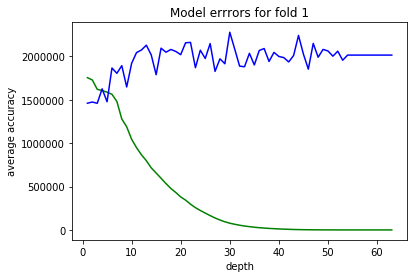

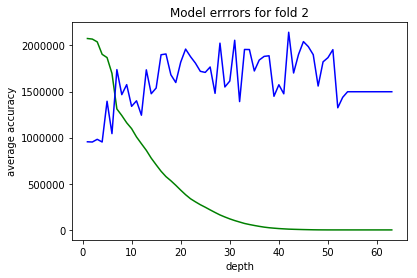

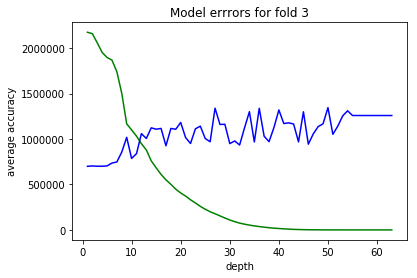

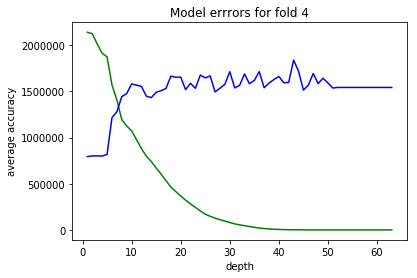

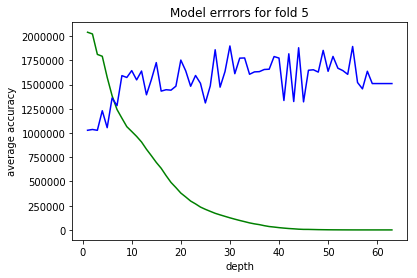

In [7]:
create_graphs(True, dev_average_errors_folds, train_average_errors_folds, 5, "fold", 63)

In [8]:
dev_depth_errors = calc_depth_avg_error(dev_average_errors_folds)
train_depth_errors = calc_depth_avg_error(train_average_errors_folds)

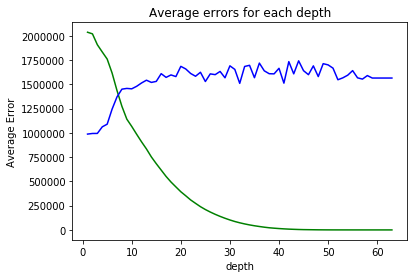

In [9]:
create_graphs(False, dev_depth_errors, train_depth_errors, 63, "depth")

In [32]:
some_dev_depth_errors = dev_depth_errors[9:63]
ind = np.argmin(some_dev_depth_errors)

ind += 10
ind

10

As is shown by the graph above, the trees with the lowest average errors were those who had a depth of 0. However, I believe that defeats the purpose of using a tree to prune away unnecessary features. So, I will do the following using the actual lowest error depth (1), as well as the lowest depth found in range 10 to 63 (10)  

In [27]:
dtr = DecisionTreeRegressor(max_depth=1, random_state=0).fit(full_df, full_df_label.values.ravel())
depth_1_test_error = sqrt_rss_values(dtr, full_df, full_test_df, full_df_label, full_test_label)

In [28]:
depth_1_test_error[1]

290349.02367745846

In [30]:
dtr = DecisionTreeRegressor(max_depth=10, random_state=0).fit(full_df, full_df_label.values.ravel())
depth_10_test_error = sqrt_rss_values(dtr, full_df, full_test_df, full_df_label, full_test_label)

In [31]:
depth_10_test_error[1]

455642.47772238025

In [56]:
best_val_accuracy = grid_rf.best_score_
test_predictions = grid_rf.predict(test)
test_accuracy = accuracy_score(test_labels, test_predictions)
best_parameters = grid_rf.best_params_
print('Best validation accuracy: ' + str(best_val_accuracy))
print('Test accuracy: ' + str(test_accuracy))
print('Best model parameters: ' + str(best_parameters))
return grid_rf.best_estimator_

NameError: name 'grid_rf' is not defined

### Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestClassifier